# Categorical variable encodings

- None (baseline)
- Label
- One-hot and "rare values" one-hot
- Feature hashing with x features
- Target
- Likelihood
- Frequency and probability
- Cat2Vec
- Deep category embedding

### Sources:

- https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512

- https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-42fd0a43b009

- https://openreview.net/pdf?id=HyNxRZ9xg

- https://arxiv.org/abs/1604.06737

### Read data

In [105]:
input_dir, basename = '../../data/adult', 'adult'

In [106]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from itertools import chain

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# AutoML
import sys
main_path = '../../'
sys.path.append(main_path + 'code/auto_ml')
sys.path.append(main_path + 'code/processing')
sys.path.append(main_path + 'code/functions')
sys.path.append(main_path + 'code/models')
sys.path.append(main_path + 'data')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from auto_ml import AutoML
import encoding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
D = AutoML(input_dir, basename)

### Quick visualization

In [5]:
D.show_feat_type()
D.get_data(processed=False).head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
Type,Numerical,Categorical,Numerical,Categorical,Numerical,Categorical,Categorical,Categorical,Categorical,Binary,Numerical,Numerical,Numerical,Categorical


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Encodings benchmark

In [109]:
# Replacing class by 0 and 1
ylabel = encoding.label(D.get_data('y'), 'class')
D.set_data(ylabel, 'y')
D.get_data().head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### One-hot with rare values management

threshold = n / uniques * coeff

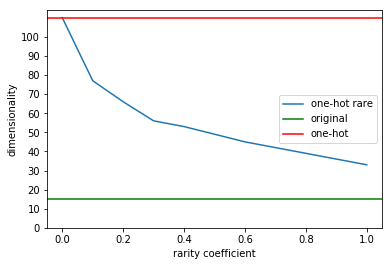

In [9]:
original = len(D.get_data().columns)

D.process_data(missing='most', code='one-hot', norm='none')
onehot = len(D.get_data(processed=True).columns)

x = np.arange(0, 1.1, 0.1)
y = []
for coeff in x:
    D.process_data(missing='most', code='one-hot', norm='none', rare=True, coeff=coeff)
    y.append(len(D.get_data(processed=True).columns))
    
import matplotlib.pyplot as plt

plt.plot(x, y, label='one-hot rare')
plt.xlabel('rarity coefficient')
plt.ylabel('dimensionality')
plt.yticks(np.arange(0, 110, 10))
plt.axhline(original, color='g', label='original')
plt.axhline(onehot, color='r', label='one-hot')
plt.legend()
plt.show()

** Scores for different coefficient values **

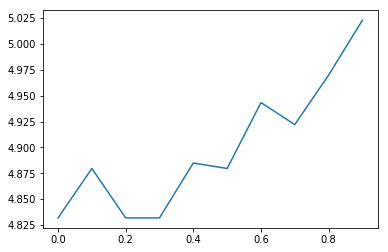

In [96]:
#clf = LogisticRegression()
clf = RandomForestClassifier(n_estimators=100)

x = np.arange(0, 1, 0.1)
y = []

# Coeff variation
for c in x:

    # Processing
    D.process_data(missing='most', code='one-hot', norm='none', rare=True, coeff=c)

    X_train = D.get_data('X_train', processed=True)
    X_test = D.get_data('X_test', processed=True)

    y_train = D.get_data('y_train', processed=True).values
    y_train = np.argmax(y_train, axis=1)
    y_test = D.get_data('y_test', processed=True).values
    y_test = np.argmax(y_test, axis=1)

    # Train and score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y.append(log_loss(y_test, y_pred))

plt.plot(x, y)

### Feature hashing

**Scores for different features number**

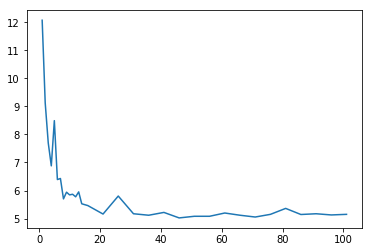

In [123]:
#clf = LogisticRegression()
clf = RandomForestClassifier(n_estimators=100)

x = list(chain(range(1,15), range(16, 106, 5)))
y = []

y_train = D.get_data('y_train').values.ravel()
y_test = D.get_data('y_test').values.ravel()
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Features number variation
for n in x:

    # Processing
    X_train = D.get_data('X_train')
    X_test = D.get_data('X_test')
    X_train = encoding.feature_hashing(X_train, n_features=n)
    X_test = encoding.feature_hashing(X_test, n_features=n)
    
    # Train and score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y.append(log_loss(y_test, y_pred))
    
plt.plot(x, y)

### Encodings comparison

label
one-hot
target
likelihood
count
feature-hashing
one-hot-rare
target-age


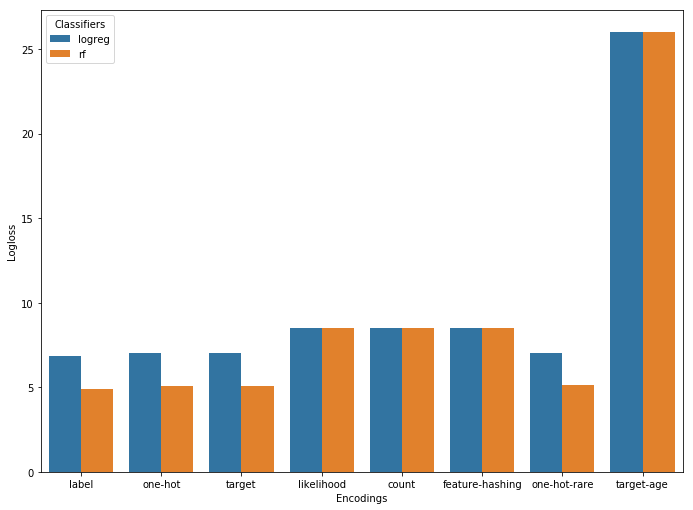

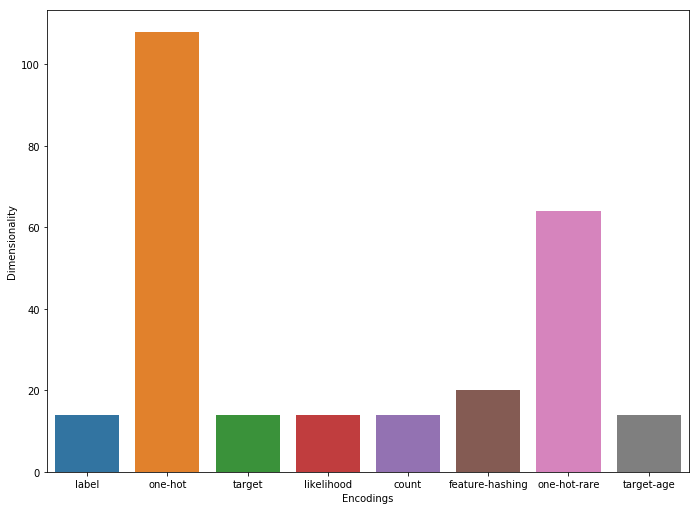

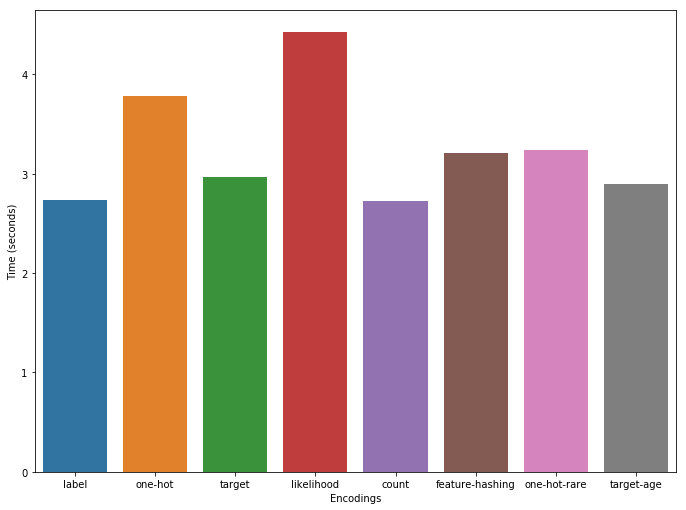

In [125]:
# benchmark
encodings = ['label', 'one-hot', 'target', 'likelihood', 'count', 'feature-hashing', 'one-hot-rare', 'target-age'] # 'probability'
classifiers = {'logreg' : LogisticRegression(),
               'rf' : RandomForestClassifier(n_estimators=100)}

# results
loss = []
encs = []
clfs = []

dims = dict()
times = dict()

for code in encodings:
    print(code)
    start = time.clock()
    
    if code == 'one-hot-rare':
        D.process_data(missing='most', code='one-hot', norm='none', rare=True, coeff=0.2)
        
    elif code == 'target-age':
        D.process_data(missing='most', code='target', norm='none', target='age')
        
    elif code == 'feature-hashing':  
        X_train = D.get_data('X_train')
        X_test = D.get_data('X_test')
        X_train = encoding.feature_hashing(X_train, n_features=20)
        X_test = encoding.feature_hashing(X_test, n_features=20)
        
    else:
        D.process_data(missing='most', code=code, norm='none', target='class')

    if 'feature-hashing' not in code: # DEGUEU, for all instead of feature hashing
        X_train = D.get_data('X_train', processed=True)
        X_test = D.get_data('X_test', processed=True)

    if 'one-hot' in code: # only for one-hot
        y_train = D.get_data('y_train', processed=True).values
        y_train = np.argmax(y_train, axis=1)
        y_test = D.get_data('y_test', processed=True).values
        y_test = np.argmax(y_test, axis=1)

    else:
        y_train = D.get_data('y_train', processed=True).values.ravel()
        y_test = D.get_data('y_test', processed=True).values.ravel()
        y_train = y_train.astype('int')
        y_test = y_test.astype('int')

    for k in classifiers.keys():  
        clf = classifiers[k]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        loss.append(log_loss(y_test, y_pred))
        encs.append(code)
        clfs.append(k)
        
    dims[code] = len(X_train.columns)
    end = time.clock()
    times[code] = end - start
    
# Plots
# LOGLOSS PLOT
results = pd.DataFrame({'Logloss': loss, 'Encodings': encs, 'Classifiers': clfs})
fig, ax = plt.subplots()
fig.set_size_inches(11.5, 8.5)
sns.barplot(x="Encodings", y="Logloss", hue="Classifiers", data=results)
plt.show()

# DIMENSIONALITY PLOT
results = pd.DataFrame({'Dimensionality': list(dims.values()), 'Encodings': list(dims.keys())})
fig, ax = plt.subplots()
fig.set_size_inches(11.5, 8.5)
sns.barplot(x='Encodings', y='Dimensionality', data=results)

# TIME PLOT
results = pd.DataFrame({'Time (seconds)': list(times.values()), 'Encodings': list(times.keys())})
fig, ax = plt.subplots()
fig.set_size_inches(11.5, 8.5)
sns.barplot(x='Encodings', y='Time (seconds)', data=results)